# Combined Analysis of Airbnb and Zillow datasets

This file contains insights obtained from joining zillow and airbnb datasets with key assumptions in place.

It provides 3 key recommendations by aggregating all information.

It looks at trends, and analyses neighbourhoods to minimize the ROI time upon purchase of property in neighbourhoods.

**Key Assumptions:**

Assumptions provided - 
1. No mortgage/interest rate will need to be accounted for 
1. Money discount rate is 0%
1. All properties are homogenous within each locale
1. Occupancy rate is 75%

Additional assumptions - 

1. Availability of each property for rental is 365 days (throughout the year)
1. Maintenance  costs (such as cleaning fee) are fixed for each property
1. Properties are rented by a customer for a period of 1 week in average
1. Rent for a customer in a listing is the same for both weekdays and weekends
1. Property tax is not considered when calculating time taken for ROI

In [1]:
# These configurations expand the Jupyter notebook 
# They also control how much output can be displayed for each cell
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 30)
pd.set_option('display.max_colwidth', 20)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import necessary python packages
from os import listdir
from os.path import join as pjoin
import pandas as pd
from time import time, sleep
import dateutil.parser
import re

import seaborn as sns
sns.set(style='whitegrid')

# Import utilities
from Utils.DataUtils import *
from Utils.UtilsViz import *

In [3]:
# Load the data
listings = pd.read_csv('./listings_2b_fe.csv')
zillow = pd.read_csv('./zillow_nyc_2007_06.csv')

Choose only the latest data point for the zillow data set.

This is under the assumption that the prices available are representative of the prices existent now.

In [4]:
# Select only relevant columns for Zillow
zcols = ["RegionName", "CountyName", "SizeRank", "2017-06"]
zillow = zillow[zcols]
zillow.rename(mapper={"2017-06":"zipcode_prop_cost"}, axis=1, inplace=True)
zillow.head()

,RegionName,CountyName,SizeRank,zipcode_prop_cost
0,10025,New York,1,1431000
1,10023,New York,3,2142300
2,10128,New York,14,1787100
3,10011,New York,15,2480400
4,10003,New York,21,2147000


In [5]:
# Select only relevant columns for Airbnb listings
acols = [
    "id",
    "neighbourhood_cleansed", 
    "neighbourhood_group_cleansed", 
    "zipcode", 
    "latitude", 
    "longitude",  
    "property_agg",
    "acc_group",
    "price", 
    "cleaning_fee", 
    "cancellation_agg"
]
listings = listings[acols]
listings.head()

,id,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,latitude,...,property_agg,acc_group,price,cleaning_fee,cancellation_agg
0,4350952,Clinton Hill,Brooklyn,11238.0,40.68485,...,Apartment,2,77.0,50.0,flexible
1,35025129,Greenpoint,Brooklyn,11222.0,40.72572,...,Apartment,2,250.0,50.0,strict
2,34204219,Park Slope,Brooklyn,11217.0,40.68092,...,Apartment,2,68.0,25.0,strict
3,12566262,Hell's Kitchen,Manhattan,10018.0,40.75756,...,Apartment,2,200.0,50.0,flexible
4,808476,Harlem,Manhattan,10032.0,40.83378,...,Apartment,2,85.0,20.0,strict


Merge the two datasets so that they can be analysed together.

In [6]:
# Combine the RegionName and Zipcode columns of both datasets
combined = pd.merge(left=listings, right=zillow, left_on="zipcode", right_on="RegionName", how="inner")
combined.drop("RegionName", inplace=True, axis=1)
combined["zipcode"] = combined["zipcode"].astype(np.int)
combined.head()

,id,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,latitude,...,cleaning_fee,cancellation_agg,CountyName,SizeRank,zipcode_prop_cost
0,34204219,Park Slope,Brooklyn,11217,40.68092,...,25.0,strict,Kings,1555,1302300
1,2908211,Park Slope,Brooklyn,11217,40.68006,...,50.0,moderate,Kings,1555,1302300
2,9685114,Fort Greene,Brooklyn,11217,40.68878,...,100.0,strict,Kings,1555,1302300
3,6609293,Park Slope,Brooklyn,11217,40.68010,...,60.0,flexible,Kings,1555,1302300
4,19979771,Fort Greene,Brooklyn,11217,40.68552,...,50.0,flexible,Kings,1555,1302300


## Zipcode level analysis

Which are the top 10 most expensive zipcodes in which Airbnb are rented?

In [7]:
zipcode_price_grp = combined[["zipcode", "price"]].groupby(["zipcode"],as_index=False).median()
zipcode_price_grp.sort_values(by="price", ascending=False).iloc[:10,:]

,zipcode,price
1,10011,320.0
2,10013,300.0
9,10036,300.0
5,10022,294.5
3,10014,292.0
6,10023,260.0
0,10003,250.0
8,10028,249.0
18,11201,220.0
7,10025,220.0


Which are the top 10 most expensive zipcodes for buying property?

In [8]:
zipcode_cost_grp = combined[["zipcode", "zipcode_prop_cost"]].groupby(["zipcode"],as_index=False).median()
zipcode_cost_grp.sort_values(by="zipcode_prop_cost", ascending=False).iloc[:10,:]

,zipcode,zipcode_prop_cost
2,10013,3316500
3,10014,2491600
1,10011,2480400
0,10003,2147000
6,10023,2142300
8,10028,2083900
5,10022,2031600
4,10021,1815600
10,10128,1787100
9,10036,1712900


Which are the 5 most expensive zipcodes in which to purchase property?

Text(0.5, 1.0, 'Zipcodes vs. Airbnb rental cost (per head)')

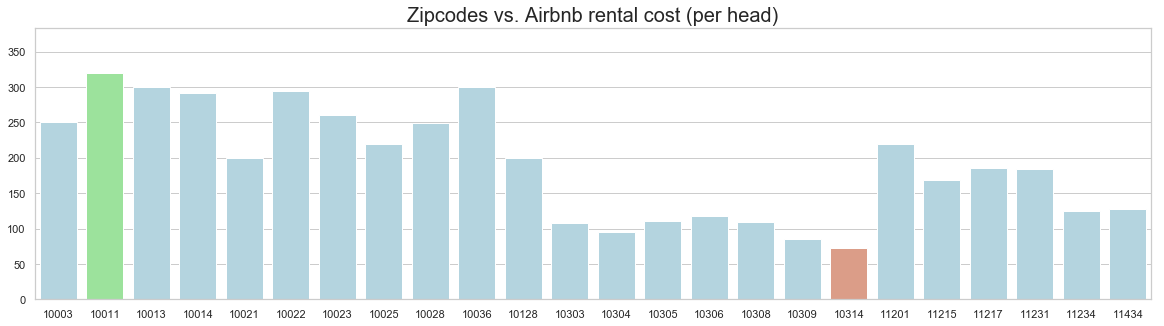

In [9]:
f,ax = plt.subplots(1,1,figsize=(20,5))
plot_bar(x="zipcode", y="price", data=zipcode_price_grp, ax=ax, annot=False)
ax.set_title("Zipcodes vs. Airbnb rental cost (per head)", fontsize=20)

Text(0.5, 1.0, 'Zipcodes vs. property cost (per head)')

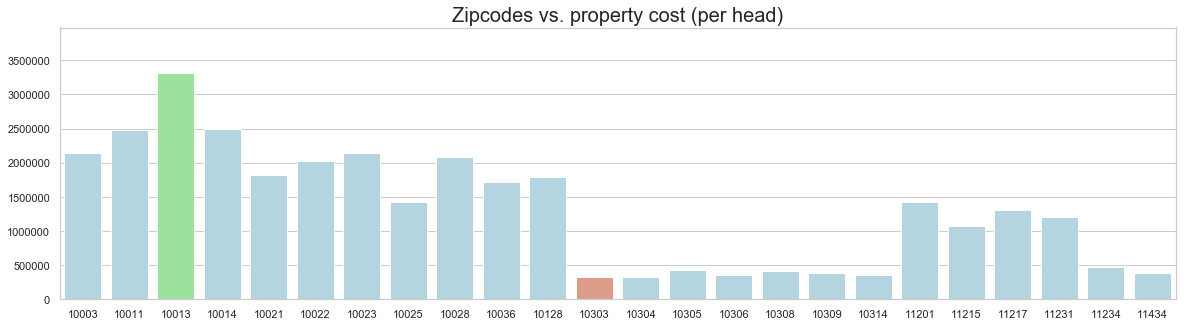

In [10]:
f,ax = plt.subplots(1,1,figsize=(20,5))
plot_bar(x="zipcode", y="zipcode_prop_cost", data=zipcode_cost_grp, ax=ax, annot=False)
ax.set_title("Zipcodes vs. property cost (per head)", fontsize=20)

While this is useful information, it's prudent to remember that Zipcodes actually stretch over multiple neighbourhoods.

Therefore, the median price of Airbnb nightly rentals per head, may be skewed based on the zipcode.

In [11]:
# Example - 
combined[["zipcode_prop_cost", "price", "cleaning_fee", "zipcode", "neighbourhood_cleansed"]].groupby(["zipcode", "neighbourhood_cleansed"]).median()

zipcode_prop_cost  \
zipcode neighbourhood_cle...                      
10003   Chelsea                         2147000   
        Civic Center                    2147000   
        East Village                    2147000   
        Gramercy                        2147000   
        Greenwich Village               2147000   
...                                         ...   
11234   East Flatbush                    476900   
        Flatlands                        476900   
        Mill Basin                       476900   
11434   Jamaica                          382300   
        Springfield Gardens              382300   

                              price  \
zipcode neighbourhood_cle...          
10003   Chelsea               515.0   
        Civic Center          199.0   
        East Village          250.0   
        Gramercy              239.0   
        Greenwich Village     495.0   
...                             ...   
11234   East Flatbush         105.0   
        Flatlands             139.0   
        Mill Basin             85.0   
11434   Jamaica               127.0   
        Springfield Gardens   144.5   

                              cleaning_fee  
zipcode neighbourhood_cle...                
10003   Chelsea                       55.0  
        Civic Center                  50.0  
        East Village                  80.0  
        Gramercy                      97.0  
        Greenwich Village            135.0  
...                                    ...  
11234   East Flatbush                 30.0  
        Flatlands                     50.0  
        Mill Basin                    80.0  
11434   Jamaica                       50.0  
        Springfield Gardens           45.0  

[82 rows x 3 columns]

## Neighbourhood level analysis

Let's calculate the median rent price, maintainence cost, and property cost for each of the neighbourhoods.

We can also aggregate the data based on the Property type (i.e., Townhouse, Apartment etc.)

In [12]:
grouping_cols = ["neighbourhood_cleansed", "property_agg", "price", "cleaning_fee", "zipcode_prop_cost"]
median_prices_group = combined[grouping_cols].groupby(by=["neighbourhood_cleansed", "property_agg"], as_index=False).median()
median_prices_group.sort_values(by="price", ascending=False).head(10)

,neighbourhood_cleansed,property_agg,price,cleaning_fee,zipcode_prop_cost
49,East Village,Townhouse,850.0,200.0,2147000
146,West Village,House,588.5,157.5,2480400
126,Theater District,Serviced apartment,584.5,200.0,1712900
27,Cobble Hill,House,525.0,200.0,1311800
112,SoHo,Loft,525.0,150.0,3316500
17,Chelsea,Loft,500.0,160.0,2486000
63,Gramercy,Loft,499.0,150.0,2147000
74,Hell's Kitchen,Serviced apartment,499.0,100.0,1712900
93,NoHo,Loft,495.0,120.0,2147000
69,Greenwich Village,Loft,490.0,142.5,2313700


Now, considering the **occupancy rate is capped at 75%**, the cash inflow we get from each property will be only 75% of its original nightly price.

If we also make a *conservative assumption* that the properties would be *booked for 1 week* at a stretch, there will be *3* instances of maintainence (cleaning) cost incurred.

Let's also make a metric that determines how long it will take to get a return of investment for each property. 

This is calculated by the property cost divided by the monthly net revenue.

In [13]:
median_prices_group["monthly_cash_inflow"] = median_prices_group["price"]*0.75*30
median_prices_group["monthly_cash_outflow"] = median_prices_group["cleaning_fee"]*3
median_prices_group["monthly_net_revenue"] = median_prices_group["monthly_cash_inflow"] - median_prices_group["monthly_cash_outflow"]

# Time taken for Return of investment
median_prices_group["ROI_years"] = np.round((median_prices_group["zipcode_prop_cost"] / median_prices_group["monthly_net_revenue"]) / 12, 1)

cols = ["neighbourhood_cleansed", "property_agg","monthly_net_revenue", "zipcode_prop_cost","ROI_years"]
median_prices_group = median_prices_group[cols].sort_values(by=["monthly_net_revenue",  "ROI_years"], ascending=[False, True])
median_prices_group.head(10)

,neighbourhood_cleansed,property_agg,monthly_net_revenue,zipcode_prop_cost,ROI_years
49,East Village,Townhouse,18525.00,2147000,9.7
146,West Village,House,12768.75,2480400,16.2
126,Theater District,Serviced apartment,12551.25,1712900,11.4
112,SoHo,Loft,11362.50,3316500,24.3
27,Cobble Hill,House,11212.50,1311800,9.7
74,Hell's Kitchen,Serviced apartment,10927.50,1712900,13.1
63,Gramercy,Loft,10777.50,2147000,16.6
93,NoHo,Loft,10777.50,2147000,16.6
17,Chelsea,Loft,10770.00,2486000,19.2
69,Greenwich Village,Loft,10597.50,2313700,18.2


Most of the desirable locations seem to be within **Manhattan**.

If we take the top 50 locations, what is the median ROI to break even?

In [14]:
print("Median ROI to break even from top 10 locations :", median_prices_group.head(50)["ROI_years"].median(), "years")

Median ROI to break even from top 10 locations : 23.65 years


Let's get the zipcodes of the top 50 locations

In [15]:
top_neighbourhoods = median_prices_group.loc[:, "neighbourhood_cleansed"].values[:50]
zipcodes = combined[combined["neighbourhood_cleansed"].isin(top_neighbourhoods)]["zipcode"].unique()
for z in zipcodes:
    print(z)

11217
10023
10025
10014
11215
10021
10036
10022
10003
10011
10013
10028
11231
11201
10128
10305


Let's also get the type of property that is suggested to purchase.

Text(0.5, 1.0, 'Most prevalent property types in Zip codes')

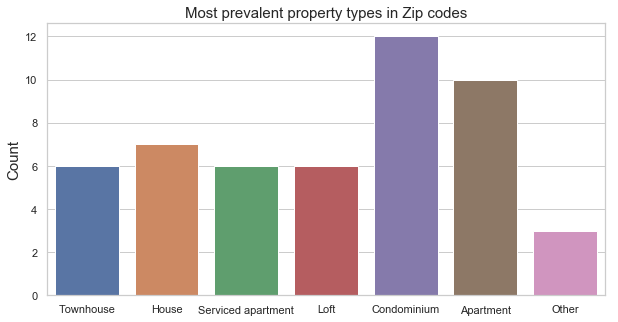

In [16]:
top_properties = median_prices_group.loc[:, "property_agg"].values[:50]
f, ax = plt.subplots(1, 1,figsize=(10,5))
g = sns.countplot(top_properties, ax=ax)
g.set_ylabel("Count", fontsize=15)
g.set_title("Most prevalent property types in Zip codes", fontsize=15)

**Condos** and **apartments** are the most occuring property types.

However, larger properties such as **Houses** and **Serviced apartments** are close as well.

# Key Recommendations

1. **Neighbourhoods in Manhattan** seem to offer the **quickest ROI** with a median of 23.65 years. The most common property types that help attain this are **Condominiums and Apartments**
1. **Investing in larger properties** can increase revenue, as they can accommodate more guests. Rental charge (on a per person level) rises till 6 people are accommodated, and stabilizes after that
1. **Spreading investments conservatively** over Manhattan as well as Brooklyn can test the waters for occupancy rate and ROI projections. Manhattan is overall more expensive than Brooklyn, however Brooklyn has more airbnb listings due to its relative affordability.

Additional data gathered over the years post-investment will enable us to re-adjust assumptions and metrics such as *Occupancy rate*.

---------

# Next steps

Several improvements can be made to the analysis to address the assumptions, as well to factor in exogenous factors such as property tax.

Some key next steps include :

1. Improving property cost using the zillow data by either collecting information from publicly available sources, or using time series forecasting to get a more accurate estimate of ROI
1. Validating or readjusting the occupancy rate after observation of property behaviour for 3-4 quarters
1. Estimating influence of applying discount rates
1. Factoring in property taxes to provide a more realistic NPV
1. Incorporating a price-prediction model for predicting estimated cash inflow using more detailed eatures from a listing. 
